<a href="https://colab.research.google.com/github/DavoodSZ1993/Dive_into_Deep_Learning/blob/main/11_3_attention_scoring_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l==1.0.0-alpha1.post0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 KB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.9/120.9 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.3 MB/s eta 0:00:00


## 11.3 Attention Scoring Functions

In [2]:
import torch
import math
from torch import nn
from d2l import torch as d2l

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


### 11.3.2 Convenience Functions

#### Masked Softmax Operation

In [3]:
def masked_softmax(X, valid_lens):
  """Perform softmax operation by masking elements on the last axis."""
  # X: 3D tensor, valid_lens: 1D or 2D tensor
  def _sequence_mask(X, valid_len, value=0):
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

  if valid_lens is None:
    return nn.functional.softmax(X, dim=1)
  else:
    shape = X.shape
    if valid_lens.dim() ==1:
      valid_lens = torch.repeat_interleave(valid_lens, shape[1])
    else: 
      valid_lens = valid_lens.reshape(-1)

    # On the last axis, replace masked elements with a very large negative value,
    # whose exponentiation outputs 0
    X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
    return nn.functional.softmax(X.reshape(shape), dim=-1)

In [4]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.4595, 0.5405, 0.0000, 0.0000],
         [0.5181, 0.4819, 0.0000, 0.0000]],

        [[0.3281, 0.2259, 0.4460, 0.0000],
         [0.3947, 0.2830, 0.3222, 0.0000]]])

In [5]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2873, 0.2930, 0.4197, 0.0000]],

        [[0.5699, 0.4301, 0.0000, 0.0000],
         [0.2812, 0.2429, 0.2015, 0.2744]]])

#### Batch Matrix Multiplication

In [6]:
Q = torch.ones((2, 3, 4))
K = torch.ones((2, 4, 6))
d2l.check_shape(torch.bmm(Q, K), (2, 3, 6))

### 11.3.3 Scaled Dot-Product Attention

In [7]:
class DotProductAttention(nn.Module):
  """"Scaled dot product attention."""
  def __init__(self, dropout, num_heads=None):
    super().__init__()
    self.dropout = nn.Dropout(dropout)
    self.num_heads = num_heads

  # Shape of queries: (batch_size, no. of queries, d)
  # Shape of keys: (batch_size, no. of key-value pairs, d)
  # Shape of values: (batch_size, no. of key-value pairs, value dimension)
  # Shape of valid_lens: (batch_size) or (batch_size, no. of queries)

  def forward(self, queries, keys, values, valid_lens=None, window_mask=None):
    d = queries.shape[-1]
    # swap the last two dimensions of keys with keys.transpose(1, 2)
    scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
    if window_mask is not None:
      num_windows = window_mask.shape[0]
      n, num_queries, num_kv_pairs = scores.shape
      # Shape of window-mask: (num_windows, no. of queries, no. of key_value pairs)
      scores = scores.reshape((n // (num_windows * self.num_heads), num_windows,
                               self.num_heads, num_queries, num_kv_pairs)) + window_mask.unsqueeze(1).unsqueeze(0)
      scores = scores.reshape((n, num_queries, num_kv_pairs))
    self.attention_weights = masked_softmax(scores, valid_lens)
    return torch.bmm(self.dropout(self.attention_weights), values)

In [8]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

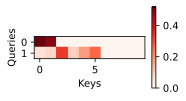

In [9]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

### 11.3.4 Additive Attention

In [10]:
class AdditiveAttention(nn.Module):
  def __init__(self, num_hiddens, dropout, **kwargs):
    super(AdditiveAttention, self).__init__(**kwargs)
    self.W_k = nn.LazyLinear(num_hiddens, bias=False)
    self.W_q = nn.LazyLinear(num_hiddens, bias=False)
    self.w_v = nn.LazyLinear(1, bias=False)
    self.dropout = nn.Dropout(dropout)

  def forward(self, queries, keys, values, valid_lens):
    queries, keys = self.W_q(queries), self.W_k(keys)
    # After dimension expansion, shape of queries: (batch_size, no. of queries, 1, num_hiddens)
    # Shape of keys: (batch_size, 1, no. of key-value pairs, num_hiddens).
    # Sum queries and keys up with broadcasting.
    features = queries.unsqueeze(2) + keys.unsqueeze(1)
    features = torch.tanh(features)
    # There is only one output of self.w_v, so we remove the last one-dimensional entry from the shape
    # Shape of Scores: (batch_size, no. of queries, no. of key-value pairs).
    scores = self.w_v(features).squeeze(-1)
    self.attention_weights = masked_softmax(scores, valid_lens)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    return torch.bmm(self.dropout(self.attention_weights), values)

In [11]:
queries = torch.normal(0, 1, (2, 1, 20))

attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


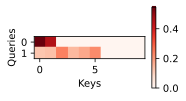

In [12]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')